### Regression

In [1]:
#---#| default_exp statistics.regression

In [2]:
from alphabase.statistics.regression import *

In [3]:
#| hide
import matplotlib.pyplot as plt

### Application example

In [4]:
#| hide
check_estimator(LOESSRegression())

/Users/georgwallmann/miniconda3/envs/alpha/lib/python3.9/site-packages/sklearn/utils/estimator_checks.py:291: SkipTestWarning: Can't test estimator LOESSRegression which requires input  of type ['1darray']
  warnings.warn(


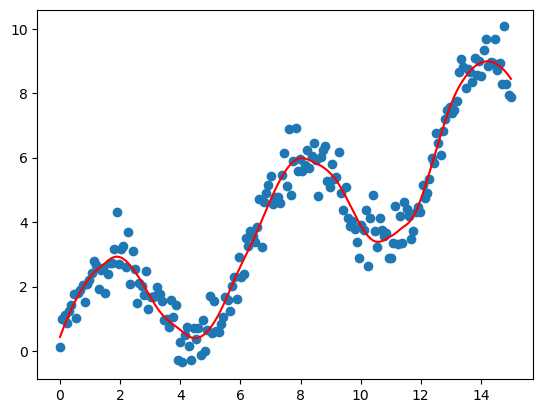

In [5]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
def noisy_1d(x):
    y = np.sin(x)
    y_err = np.random.normal(y,0.5)
    return y + y_err + 0.5 * x

x_train = np.linspace(0,15,200)
y_train = noisy_1d(x_train)

x_test = np.linspace(0,15,200)
y_test = LOESSRegression().fit(x_train, y_train).predict(x_test)

plt.scatter(x_train,y_train)
plt.plot(x_test,y_test,c='r')
plt.show()

### Weight function

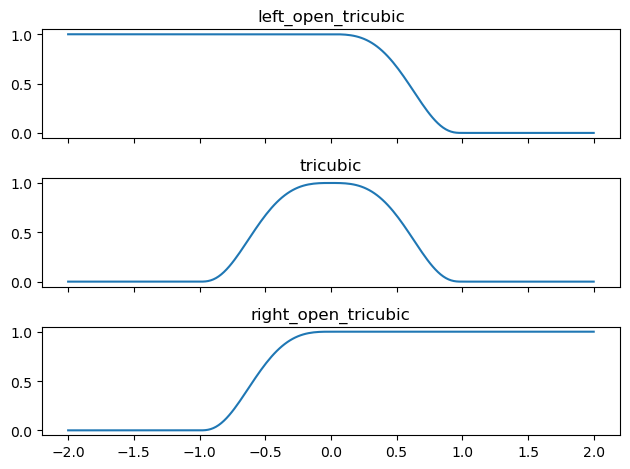

In [6]:
fig, axs = plt.subplots(nrows=3,sharex=True)

x = np.linspace(-2,2,200)
y = left_open_tricubic(x)
axs[0].plot(x,y)
axs[0].set_title('left_open_tricubic')

x = np.linspace(-2,2,200)
y = tricubic(x)
axs[1].plot(x,y)
axs[1].set_title('tricubic')

x = np.linspace(-2,2,200)
y = right_open_tricubic(x)
axs[2].plot(x,y)
axs[2].set_title('right_open_tricubic')

fig.tight_layout()
plt.show()

#| hide
### Unit Tests for Edge Cases

In [7]:
#| hide

def noisy_1d(x):
    y = np.sin(x)
    y_err = np.random.normal(y,0.5)
    return y + y_err + 0.5 * x

for uniform in [True, False]:

    # To few datapoints for choosen number of kernels

    x_train = np.linspace(0,15,6)
    y_train = noisy_1d(x_train)
    x_test = np.linspace(0,15,10)
    y_test = LOESSRegression(n_kernels=4, polynomial_degree=2, uniform=uniform).fit(x_train, y_train).predict(x_test)

    # Extrapolation

    x_train = np.linspace(0,15,60)
    y_train = noisy_1d(x_train)
    x_test = np.linspace(-10,25,10)
    y_test = LOESSRegression(n_kernels=4, polynomial_degree=2, uniform=uniform).fit(x_train, y_train).predict(x_test)

    # single datapoint inference

    x_train = np.linspace(0,15,100)
    y_train = noisy_1d(x_train)
    x_test = np.linspace(10,10,1)
    y_test = LOESSRegression(n_kernels=4, polynomial_degree=2, uniform=uniform).fit(x_train, y_train).predict(x_test)

    # extrapolation when no other points are interpolated

    x_train = np.linspace(0,15,60)
    y_train = y = np.sin(x_train)
    x_test = np.linspace(-2,-1,1)
    y_test = LOESSRegression(n_kernels=4, polynomial_degree=2, uniform=uniform).fit(x_train, y_train).predict(x_test)
    assert (-2.604 - y_test) < 0.01

    # uniform kernels instead of density distribted
    x_train = np.concatenate([np.linspace(0,2,30), np.linspace(8,10,30)])
    y_train = y = np.sin(x_train)
    y_test = LOESSRegression(n_kernels=6, polynomial_degree=3,uniform=uniform).fit(x_train, y_train).predict(x_test)

Curve fitting with 4 kernels and polynomials of 2 degree requires at least 12 datapoints.
Number of kernels will be reduced to 2 kernels.
Too few datapoints per kernel. Uniform kernels will be replaced by density kernels.
Curve fitting with 4 kernels and polynomials of 2 degree requires at least 12 datapoints.
Number of kernels will be reduced to 2 kernels.
